# One-Shot Learning for Modulation Format Identification in Evolving Optical Networks

Main file for the generation of the results presented in Sec. 3 of the summary. The file is based on the one made available at https://towardsdatascience.com/one-shot-learning-with-siamese-networks-using-keras-17f34e75bb3d.

README file has instructions for recommended platform and libraries versions.

In [1]:
import time
import imageio
import pickle
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Lambda
from keras.models import Model, Sequential
from keras import optimizers, initializers
from keras.utils import plot_model, np_utils
from keras import backend as K

import os
import matplotlib.pyplot as plt

from IPython import display

%matplotlib inline
# %config InlineBackend.figure_format = 'svg'

from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Times New Roman', 'Times']
rcParams['font.size'] = 20

## Setting definitions of the project and folder for the dataset

In [2]:
# base folder of the files
folder = './dataset/' # adjust this folder according to the location of the dataset in your computer
scenarios = []
scenarios.append('4QAM_OSNR45dB')
scenarios.append('4QAM_OSNR12dB')
scenarios.append('16QAM_OSNR45dB')
scenarios.append('16QAM_OSNR20dB')

scenarios.append('64QAM_OSNR45dB')
scenarios.append('64QAM_OSNR26dB')

scenarios.append('16C-QAM_OSNR45dB')
scenarios.append('16C-QAM_OSNR20dB')

scenarios.append('64C-QAM_OSNR45dB')
scenarios.append('64C-QAM_OSNR26dB')

points_per_symbol = 2000
seed = 100
np.random.seed(seed)

## Importing the dataset

In [3]:
train_classes = [0, 1, 2, 3] # only 4 and 16 squared-shaped constellations are used for the training/validation
test_classes = [4, 5, 6, 7, 8, 9]

X = np.zeros((len(scenarios) * 100, 520, 520))
Y = np.zeros((len(scenarios) * 100), dtype=int)

X_train = np.zeros((len(train_classes) * 50, 520, 520))
Y_train = np.zeros((len(train_classes) * 50), dtype=int)

X_validation = np.zeros((len(train_classes) * 25, 520, 520))
Y_validation = np.zeros((len(train_classes) * 25), dtype=int)

X_test = np.zeros((len(train_classes) * 25 + len(test_classes) * 100, 520, 520))
Y_test = np.zeros((len(train_classes) * 25 + len(test_classes) * 100), dtype=int)

# configuration of the cut to be done in the diagrams
cut_x = 68
cut_y = 168

for id_scenario, scenario in enumerate(scenarios):
    for id_figure in range(100): # for each scenario we have 100 images
        image = imageio.imread(folder + scenario + '/Fig_'+ scenario + '_PointsPerSymb_' + str(points_per_symbol) + '_constN_' + str(id_figure + 1) + '.png')
        shape = image.shape
        r, g, b = image[cut_x:shape[0]-cut_x, cut_y+20:shape[1] - cut_y + 1, 0], image[cut_x:shape[0]-cut_x, cut_y+20:shape[1] - cut_y + 1, 1], image[cut_x:shape[0]-cut_x, cut_y+20:shape[1] - cut_y + 1, 2]
        gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
        index = id_scenario * 100 + id_figure
        X[index, :, :] = gray / 255.
    index_full = id_scenario * 100
    
    clazz = id_scenario # the class is obtained by the index of the scenario list
    print(clazz, id_scenario, scenario, end='\t')

    Y[index_full:index_full+100] = clazz
    
    if clazz in train_classes:
        index_train = id_scenario * 50
        X_train[index_train:index_train + 50, :, :] = X[index_full:index_full + 50, :, :]
        Y_train[index_train:index_train + 50] = clazz

        index_validation = id_scenario * 25
        print(index_validation, ':', index_validation + 25)
        X_validation[index_validation:index_validation + 25, :, :] = X[index_full + 50:index_full + 50 + 25, :, :]
        Y_validation[index_validation:index_validation + 25] = clazz #evm_truth[scenario]
    
        index_test = id_scenario * 25
        X_test[index_test:index_test + 25, :, :] = X[index_full + 50 + 25:index_full + 50 + 25 + 25, :, :]
        Y_test[index_test:index_test + 25] = clazz #evm_truth[scenario]
    else:
        index_test = len(train_classes) * 25 + (id_scenario - len(train_classes)) * 100
        print(index_test, ':', index_test + 100)
        X_test[index_test:index_test + 100, :, :] = X[index_full:index_full + 100, :, :]
        Y_test[index_test:index_test + 100] = clazz #evm_truth[scenario]

print('done')

0 0 4QAM_OSNR45dB	0 : 25
1 1 4QAM_OSNR12dB	25 : 50
2 2 16QAM_OSNR45dB	50 : 75
3 3 16QAM_OSNR20dB	75 : 100
4 4 64QAM_OSNR45dB	100 : 200
5 5 64QAM_OSNR26dB	200 : 300
6 6 16C-QAM_OSNR45dB	300 : 400
7 7 16C-QAM_OSNR20dB	400 : 500
8 8 64C-QAM_OSNR45dB	500 : 600
9 9 64C-QAM_OSNR26dB	600 : 700
done


### Random samples of the constellation diagrams can be plotted to validate the correct importing.

<Figure size 432x288 with 0 Axes>

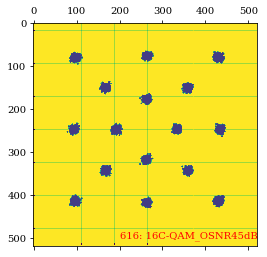

<Figure size 432x288 with 0 Axes>

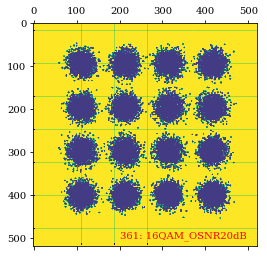

In [24]:
for i in range(2):
    image = np.random.choice(X.shape[0], size=1)[0]
#     print(image, scenarios[Y_train[image]])
    plt.figure()
    plt.matshow(X[image, :, :])
    plt.text(200, 500, '{}: {}'.format(image, scenarios[Y[image]]), color='red')
    plt.show()
    plt.close()

## Defining the ML model

In the following, we define the architecture of the Siamese convolutional neural network.

In [5]:
input_shape = (520, 520, 1) # shape of the constellation diagrams to be input to the model

left_input = Input(shape=input_shape, name='left_in')
right_input = Input(shape=input_shape, name='right_in')

model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', name='conv_1'))
model.add(MaxPooling2D(pool_size=(2, 2), name='max_1'))
model.add(Conv2D(4, (2, 2), activation='relu', name='conv_2'))
model.add(MaxPooling2D(pool_size=(2, 2), name='max_2'))
model.add(Flatten())
model.add(Dense(100, activation='sigmoid'))

encoded_l = model(left_input)
encoded_r = model(right_input)

L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
L1_distance = L1_layer([encoded_l, encoded_r])
    
# Add a dense layer with a sigmoid unit to generate the similarity score
prediction = Dense(1,activation='sigmoid')(L1_distance)
    
# Connect the inputs with the outputs
siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

# model = Model(inputs=input_0, outputs=out_0)
loss = 'binary_crossentropy'

siamese_net.compile(optimizer=optimizers.Adam(lr=0.001), loss=loss, metrics=['accuracy'])
siamese_net.summary()

# plot_model(siamese_net, to_file=results_folder + '/model.png', show_shapes=True, show_layer_names=True)
# display.Image(filename=results_folder + '/model.png')

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
left_in (InputLayer)            (None, 520, 520, 1)  0                                            
__________________________________________________________________________________________________
right_in (InputLayer)           (None, 520, 520, 1)  0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 100)          6656920     left_in[0][0]                    
                                                                 right_in[0][0]                   
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None

In [6]:
def get_batch(batch_size, s="train"):
    """Create batch of n pairs, half same class, half different class"""
    if s == 'train':
        X = X_train
        Y = Y_train
        categories = train_classes
    elif s == 'validation':
        X = X_validation
        Y = Y_validation
        categories = train_classes
    elif s == 'test':
        X = X_test
        Y = Y_test
        categories = test_classes
    else:
        raise ValueError('type of dataset to be used is not defined!')
    
    n_examples, w, h = X.shape

    # initialize 2 empty arrays for the input image batch
    pairs=[np.zeros((batch_size, h, w,1)) for i in range(2)]
    
    # initialize vector for the targets
    targets=np.zeros((batch_size,))
    
    # make one half of it '1's, so 2nd half of batch has same class
    targets[batch_size//2:] = 1
    for i in range(batch_size):
        category = np.random.choice(categories, size=1)[0]
        idx_1 = np.random.choice(np.where(Y == category)[0], size=1)[0]
        pairs[0][i,:,:,:] = X[idx_1].reshape(w, h, 1)
        
        # pick images of same class for 1st half, different for 2nd
        if i >= batch_size // 2:
            idx_2 = np.random.choice(np.where(Y == Y[idx_1])[0], size=1)[0]
        else: 
            # add a random number to the category modulo n classes to ensure 2nd image has a different category
            category_2 = category
            while category == category_2:
                category_2 = np.random.choice(categories)
            idx_2 = np.random.choice(np.where(Y == category_2)[0], size=1)[0]
        pairs[1][i,:,:,:] = X[idx_2].reshape(w, h,1)
    return pairs, targets

In [7]:
def plot_batch(inputs, targets):
    """Creates the visualization of a batch"""
    n_comparison, n_samples, x, y, z = np.shape(inputs)
    for sample in range(n_samples):
        fig, axs = plt.subplots(1, 2, figsize=(10, 3))

        axs[0].matshow(inputs[0][sample].reshape(x, y))
        axs[0].axis('off')
        axs[1].matshow(inputs[1][sample, :, :, :].reshape(x, y))
        axs[1].axis('off')
#         axs[2].text(1, 1, str(targets[sample]))
#         axs[2].axis('off')
        axs[0].set_title('Similarity score: {}'.format(targets[sample]))
        plt.tight_layout()
        plt.show()
        plt.close()

## Visualizing batches of one-shot learning tasks

By using the following code, one can visualiza how the tasks are created.

Batch 1


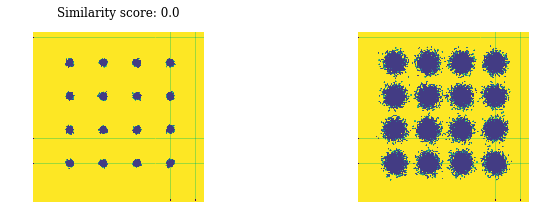

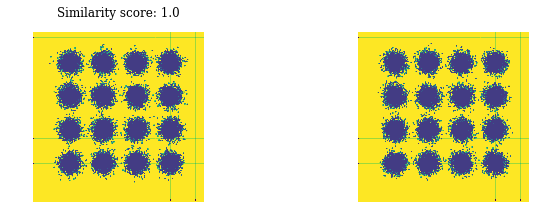

Batch 2


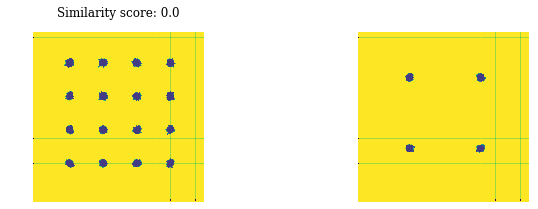

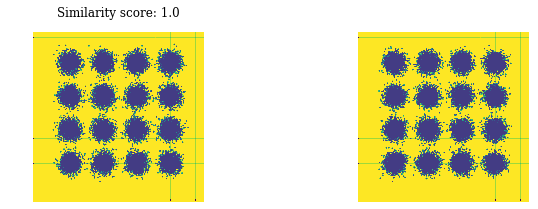

In [26]:
n_iter = 2 # number of iterations of the algorithms
batch_size = 2 # number of tasks per batch
for i in range(1, n_iter+1):
    (inputs, targets) = get_batch(batch_size)
    print('Batch', i)
    plot_batch(inputs, targets)

In [9]:
def test_oneshot(model, N, k, s = "validation", verbose = 0):
    """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
    n_correct = 0
    if verbose:
        print("Evaluating model on {} random {} way one-shot learning tasks ... \n".format(k,N))
    for i in range(k):
        inputs, targets = make_oneshot_task(N, s)
#         plot_batch(inputs, targets)
        probs = model.predict(inputs)
#         print(probs[:,0], np.argmax(probs), targets)
        if np.argmax(probs) == np.argmax(targets):
            n_correct+=1
    percent_correct = (100.0 * n_correct / k)
    if verbose:
        print("Got an average of {}% {} way one-shot learning accuracy \n".format(percent_correct,N))
    return percent_correct

In [10]:
def generate(batch_size, s="train"):
    """a generator for batches, so model.fit_generator can be used. """
    while True:
        pairs, targets = get_batch(batch_size,s)
        yield (pairs, targets)

In [11]:
def make_oneshot_task(N, s="validation", modulation=None):
    """Create pairs of test image, support set for testing N way one-shot learning. """
    if s == 'train':
        X = X_train
        Y = Y_train
        max_i = min(N, len(train_classes))
        categories = [train_classes[i] for i in range(max_i)]
    elif s == 'validation':
        X = X_validation
        Y = Y_validation
        max_i = min(N, len(train_classes))
        categories = [train_classes[i] for i in range(max_i)]
    elif s == 'test':
        X = X_test
        Y = Y_test
        temp = train_classes + test_classes
        categories = [temp[i] for i in range(N)]
    else:
        raise ValueError('type of dataset to be used is not defined!')

    n_examples, w, h = X.shape

    if modulation is not None: # if modulation is specified, select characters for that language
        indices = np.where(Y == modulation)[0]
    else:
        modulation = np.random.choice(categories, size=1)[0]
        indices = np.where(Y == modulation)[0]

    pairs=[np.zeros((N, h, w,1)) for i in range(2)]
    
    ex1, ex2 = np.random.choice(indices, replace=False, size=(2,))
    pairs[0][:, :, :, :] = np.asarray([X[ex1,:,:]]*N).reshape(N, w, h, 1)

    pairs[1][0,:,:,:] = X[ex2].reshape(w, h, 1)
    other_indices = np.random.choice(np.where(Y != modulation)[0], replace=False, size=(N-1,))
#     print('others', other_indices, Y[other_indices])
    pairs[1][1:, :, :, :] = X[other_indices].reshape(N-1, w, h, 1)
    targets = np.zeros((N,))
    targets[0] = 1
    targets, pairs[0], pairs[1] = shuffle(targets, pairs[0], pairs[1])
#     pairs = [test_image,support_set]
#     pairs = np.reshape(pairs, newshape=np.shape(pairs))
#     print(np.shape(pairs), np.shape(targets))
    return pairs, targets

## Some definitions for the model and results to be saved

In [12]:
model_path = './results/'
# Hyper parameters
evaluate_every = 2 # interval for evaluating on one-shot tasks
batch_size = 30
n_iter = 10 # No. of training iterations
N_way = 4 # how many classes for testing one-shot tasks
n_val = 10 # how many one-shot tasks to validate on
best = -1

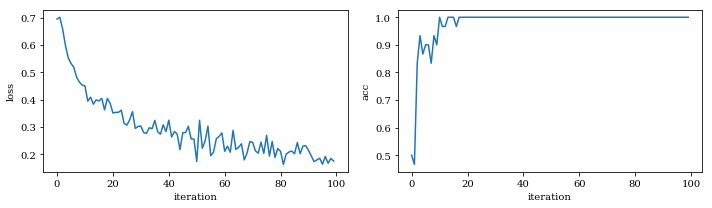

In [13]:
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()
n_iter = 100
losses = {}
for metric in siamese_net.metrics_names:
    losses[metric] = []

for i in range(1, n_iter+1):
    (inputs, targets) = get_batch(batch_size)
    loss = siamese_net.train_on_batch(inputs, targets)
    for metric, loss_value in zip(siamese_net.metrics_names, loss):
        losses[metric].append(loss_value)
        
    if i % evaluate_every == 0:
        
        fig, axs = plt.subplots(1, len(losses), figsize=(10, 3))
        for j, metric in enumerate(losses):
            axs[j].set_xlabel('iteration')
            axs[j].set_ylabel(metric)
            axs[j].plot(losses[metric])
        plt.tight_layout()
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.close()
        time.sleep(1.0)
        
#         print("Time for {0} iterations: {1} mins".format(i, (time.time()-t_start)/60.0))

with open(model_path + 'model.json', 'w') as f:
    f.write(siamese_net.to_json())
siamese_net.save_weights(model_path + 'weights.h5')
siamese_net.save(model_path + 'model.h5')

# plotting final plot and saving it to file
display.clear_output(wait=True)
fig, axs = plt.subplots(1, len(losses), figsize=(10, 3))
for j, metric in enumerate(losses):
    axs[j].set_xlabel('iteration')
    axs[j].set_ylabel(metric)
    axs[j].plot(losses[metric])
plt.tight_layout()
plt.savefig(model_path + 'training.pdf')
plt.close()

In [16]:
#del siamese_net # for testing purposes

## comparing

In [17]:
def nearest_neighbour_correct(pairs,targets):
    """returns 1 if nearest neighbour gets the correct answer for a one-shot task
        given by (pairs, targets)"""
    L2_distances = np.zeros_like(targets)
    for i in range(len(targets)):
        L2_distances[i] = np.sum(np.sqrt(pairs[0][i]**2 - pairs[1][i]**2))
    if np.argmin(L2_distances) == np.argmax(targets):
        return 1
    return 0

In [18]:
def test_nn_accuracy(N_ways,n_trials, s='validation'):
    """Returns accuracy of NN approach """
    print("Evaluating nearest neighbour on {} unique {} way one-shot learning tasks ...".format(n_trials,N_ways))

    n_right = 0
    
    for i in range(n_trials):
        pairs,targets = make_oneshot_task(N_ways, s)
        correct = nearest_neighbour_correct(pairs,targets)
        n_right += correct
    return 100.0 * n_right / n_trials

In [19]:
def test_clf_accuracy(clf, N_ways,n_trials, s='validation'):
    """Returns accuracy of NN approach """
    print("Evaluating nearest neighbour on {} unique {} way one-shot learning tasks ...".format(n_trials,N_ways))

    n_right = 0
    
    for i in range(n_trials):
        pairs,targets = make_oneshot_task(N_ways, s)
        X = clf.predict(pairs)
        print(X, targets)
        n_right += correct
    return 100.0 * n_right / n_trials

In [20]:
ways = np.arange(1,11,1) # up to 10 classes can be evaluated
resume =  False
trials = 150

In [21]:
val_accs, train_accs, test_accs, nn_accs = [], [], [], []
for N in ways:    
    val_accs.append(test_oneshot(siamese_net, N, trials, "validation", verbose=True))
    train_accs.append(test_oneshot(siamese_net, N, trials, "train", verbose=True))
    test_accs.append(test_oneshot(siamese_net, N, trials, "test", verbose=True))
    nn_acc = test_nn_accuracy(N, trials, s='test')
    nn_accs.append(nn_acc)
    print ("NN Accuracy = ", nn_acc)
    print("---------------------------------------------------------------------------------------------------------------")

print('done')

Evaluating model on 150 random 1 way one-shot learning tasks ... 

Got an average of 100.0% 1 way one-shot learning accuracy 

Evaluating model on 150 random 1 way one-shot learning tasks ... 

Got an average of 100.0% 1 way one-shot learning accuracy 

Evaluating model on 150 random 1 way one-shot learning tasks ... 

Got an average of 100.0% 1 way one-shot learning accuracy 

Evaluating nearest neighbour on 150 unique 1 way one-shot learning tasks ...
NN Accuracy =  100.0
---------------------------------------------------------------------------------------------------------------
Evaluating model on 150 random 2 way one-shot learning tasks ... 

Got an average of 100.0% 2 way one-shot learning accuracy 

Evaluating model on 150 random 2 way one-shot learning tasks ... 

Got an average of 100.0% 2 way one-shot learning accuracy 

Evaluating model on 150 random 2 way one-shot learning tasks ... 

Got an average of 100.0% 2 way one-shot learning accuracy 

Evaluating nearest neighbour

/home/carda/.conda/envs/venv37-tf13/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  


NN Accuracy =  53.333333333333336
---------------------------------------------------------------------------------------------------------------
Evaluating model on 150 random 3 way one-shot learning tasks ... 

Got an average of 100.0% 3 way one-shot learning accuracy 

Evaluating model on 150 random 3 way one-shot learning tasks ... 

Got an average of 100.0% 3 way one-shot learning accuracy 

Evaluating model on 150 random 3 way one-shot learning tasks ... 

Got an average of 100.0% 3 way one-shot learning accuracy 

Evaluating nearest neighbour on 150 unique 3 way one-shot learning tasks ...
NN Accuracy =  37.333333333333336
---------------------------------------------------------------------------------------------------------------
Evaluating model on 150 random 4 way one-shot learning tasks ... 

Got an average of 100.0% 4 way one-shot learning accuracy 

Evaluating model on 150 random 4 way one-shot learning tasks ... 

Got an average of 100.0% 4 way one-shot learning accurac

## Saving the results to the file

In [22]:
with open(model_path + 'results.h5', 'wb') as f:
    pickle.dump({'losses': losses,
                'val_accs': val_accs,
                'train_accs': train_accs,
                 'test_accs': test_accs,
                'nn_accs': nn_accs,
                'ways': ways}, f)

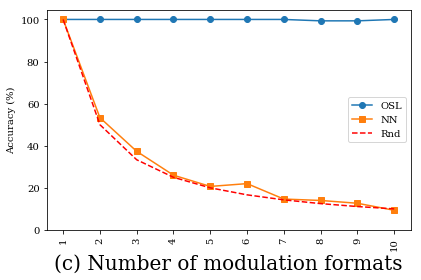

In [23]:
plt.figure()

plt.plot(ways, test_accs, label="OSL", marker='o')
plt.plot(ways, nn_accs, label="NN", marker='s')
plt.plot(ways, 100.0/ways, label="Rnd", color='red', linestyle='--')

plt.xlabel("(c) Number of modulation formats", fontsize=20)
plt.ylabel("Accuracy (%)")
plt.xticks(range(1, len(scenarios)+1), rotation=90)

ylim = plt.ylim()
plt.ylim(0, ylim[1])
plt.legend(loc='center right')
plt.tight_layout()
plt.savefig(model_path + 'benchmark.pdf')
plt.show()

## Testing and plotting available in the file `testing-plotting.ipynb`